In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import xarray as xr
from sklearn.metrics import r2_score

sys.path.append('../lib')
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread
from plot_utils import plot_region_tests, annotate_per_region_axes, axis_off_save_labels

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'mas_match_control'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
conds = ('RF 1', 'RF 2', 'M.pt.', 'Match RF 1', 'Match RF 2')
pal = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cond_palette = dict(zip(conds, (pal[i] for i in (1, 0, 4, 1, 0))))
cond_ls =  dict(zip(conds, ('-', '-', '-', '--', '--')))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'boots_sem'
stat_tests = (
    # ('RF 1', 'Match RF 1', 'greater'),
    ('RF 2', 'Match RF 2', 'greater'),)

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('maps',)}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
        except (KeyError, AssertionError):
            continue

    ds = xr.load_dataset(fp, group=analysis_name+'/data', engine='h5netcdf')
    verified_update(coords, dict(rpos=ds['pos'].values, time=ds['time'].values))

    results['maps'].append(ds['corr_per_split'].mean('split').values)

    unit_names = ds['unit'].values.astype(str)
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 rpos (9,) float64
	 time (31,) float64
results:
	maps           	(2, 31, 9, 26946)	float32
	Session        	(26946,)	<U10
	Unit           	(26946,)	<U4
668 sessions


# Select units

In [5]:
maps = results['maps']
rpos_ = list(coords['rpos'])
ipos = [rpos_.index(v) for v in (0, 1, 0.5)]
result_vals = np.concatenate([  # shape (3 [orig] + 2 [match], npos, nt, nu)
    maps[0,:,ipos,:],
    maps[1,:,ipos[:2],:]], axis=0)
result_vals = result_vals.reshape(-1, *result_vals.shape[-2:])
del results
result_vals.shape  # shape (orig[3] + match[2] x npos, nt, nu)

(5, 31, 26946)

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)

result_vals = result_vals[...,unit_sel]
maps = maps[...,unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig7cd.csv.gz', index=False)

> Selected units: n = 26946 of 26946 (100.0% of data, 99.9% of selection) based on visually_selective.csv.gz
> Selected units: n = 26524 of 26946 (98.4%) with valid values
> Excluded 2 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Ot           5     0.007886
	CIT    Re          28     0.024096
  Selected units: n = 26491 of 26524 (99.9%)


# Plot full maps

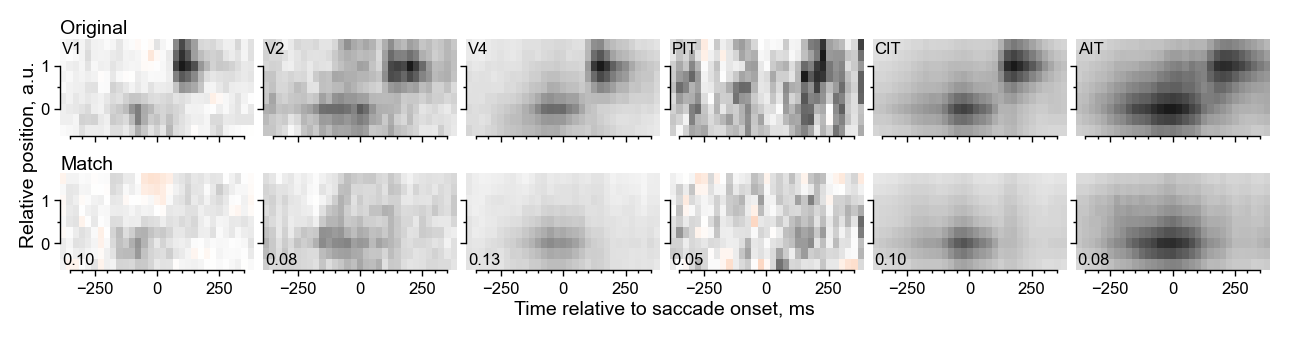

In [7]:
ncol = len(regions)
fig, axs_ = plt.subplots(2, ncol, figsize=(1.3*ncol,1.6), sharex=True, sharey=True)
axs = axs_.ravel()
plt.subplots_adjust(hspace=0.2, wspace=.05)

locs = (coords['time'], coords['rpos'])
steps = np.zeros(2)
for i, loc in enumerate(locs):
    step = np.unique(np.diff(loc))
    assert step.size == 1
    steps[i] = step
im_ext = np.concatenate([[v.min(), v.max()] for v in locs]) \
    + (np.array([-.5,.5]) * steps[:,None]).ravel()
a, b = im_ext.reshape(2, 2).ptp(1)
aspect = a / b / 2
imshow_kws = dict(origin='lower', extent=im_ext, cmap='RdGy', aspect=aspect)
text_kws = dict(ha='left', c='k', fontsize=6)

for j, (region, axs__) in enumerate(zip(regions, axs_.T)):
    usel = unit_df[unit_df['Region']==region]['Index'].values
    rfs = np.nanmean(maps[...,usel], axis=-1)
    vm = np.nanmax(np.abs(rfs))
    for i, ax in enumerate(axs__):
        ax.imshow(rfs[i].T, vmin=-vm, vmax=vm, **imshow_kws)
        if i == 0:
            ax.text(.01, .975, region, va='top', transform=ax.transAxes, **text_kws)
        else:
            ax.text(.01, .025, '%.2f'%vm, va='bottom', transform=ax.transAxes, **text_kws)
        if j == 0:
            ax.set_title(('Original','Match')[i], pad=(2,0)[i], loc='left')

xlim = im_ext[:2]
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
ylim = im_ext[2:]
ytks = (0, 1)
ymtks = (.5,)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks[0], xmtks[-1])
    ax.set_ylim(ylim)
    ax.set_yticks(ytks)
    ax.set_yticks(ymtks, minor=True)
    ax.spines['left'].set_bounds(ytks[0], ytks[-1])

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to saccade onset, ms', labelpad=8)
ax.set_ylabel('Relative position, a.u.', labelpad=8)

plt.savefig('plots/fig7c.png')

# Adjust baseline

In [8]:
iconds = (3, 0)

print(
    'Fitting baseline adjustment by linear regression from',
    conds[iconds[0]], 'to', conds[iconds[1]], 'across time')
x, y = (np.nanmean(result_vals[i], 1) for i in iconds)
x_ = np.vstack([x, np.ones(len(x))]).T
lsq = np.linalg.lstsq(x_, y[:,None], rcond=None)[0]
y_ = (x_ @ lsq).ravel()
res = y - y_
rres = np.abs(res/x) * 100
print(f'Fit R2: {r2_score(y, y_):.4f}')
print(f'Mean rel. residual: {rres.mean():.1f}% ± {rres.std():.1f}%')
print(f'Slope: {lsq[0,0]:.4f}\tintercept: {lsq[1,0]:.4f}')

print('Applying baseline adjustment for conditions:')
for i, cond in enumerate(conds):
    if not cond.startswith('Match'): continue
    result_vals[i] = result_vals[i] * lsq[0,0] + lsq[1,0]
    print('\t'+cond)

Fitting baseline adjustment by linear regression from Match RF 1 to RF 1 across time
Fit R2: 0.9984
Mean rel. residual: 1.4% ± 1.1%
Slope: 1.0844	intercept: 0.0011
Applying baseline adjustment for conditions:
	Match RF 1
	Match RF 2


# Plot select positions

In [9]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals,
    spread_type=spread_type,
    conds=conds,
    stat_tests=stat_tests)

center/spread estimate: boots_sem


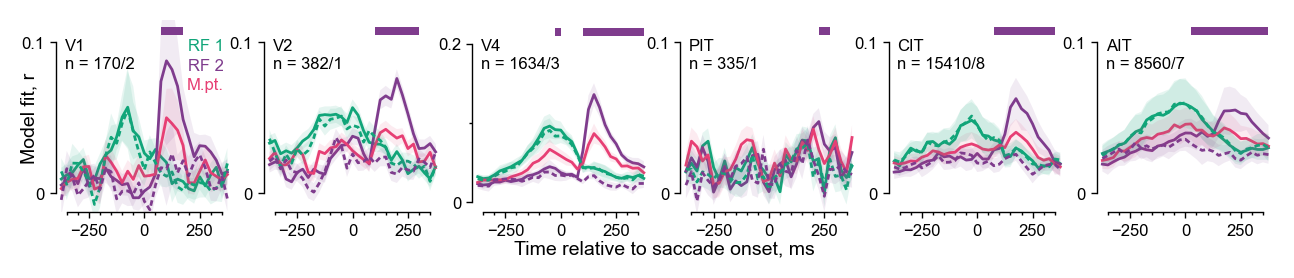

In [10]:
ncol = len(regions)
fig, axs = plt.subplots(1, ncol, figsize=(1.31*ncol,1.25), sharex=True)
plt.subplots_adjust(wspace=0.175)

ts = coords['time']
for region, ax in zip(regions, axs):
    m, bs = summary['one-level_center_boots'][region]
    for icond, cond in enumerate(conds):
        color = cond_palette[cond]
        ax.plot(ts, m[icond], color=color, ls=cond_ls[cond], zorder=2+icond/10)
        spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
        ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.95+icond/10)

ybound = {region: (0, .2) if region == 'V4' else (0, .1) for region in regions}
ymax = plot_region_tests(
    xs=ts, axs=axs, regions=regions,
    summary=summary,  palette=cond_palette, ybound=ybound)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())

for region, ax in zip(regions, axs):
    ybound_ = ybound[region]
    ylim = (-.0125, ymax[region])
    ymtks = np.arange(*ybound_, .1)
    ax.set_ylim(ylim)
    ax.set_yticks(ybound_, list(map(str, ybound_)))
    ax.set_yticks(ymtks, minor=True)
    ax.spines['left'].set_bounds(ybound_)

ax = axs[0]
ax.set_ylabel('Model fit, r')
tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-.1, .05, transform=tform)

ax = fig.add_subplot(111)
axis_off_save_labels(ax)
ax.set_xlabel('Time relative to saccade onset, ms', labelpad=10)

annotate_per_region_axes(
    axs,
    regions,
    ns_per_region=summary['two-level_nunit'],
    conds=conds[:3],
    palette=cond_palette,
    h=.9,
    r=.95)

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig7d.png')

In [11]:
for region in regions:
    for i, test in enumerate(stat_tests):
        m = summary['reject_dict'][(region,test)]
        print(region, test, ts[m], sep='\t')

V1	('RF 2', 'Match RF 2', 'greater')	[ 75. 100. 125. 150.]
V2	('RF 2', 'Match RF 2', 'greater')	[100. 125. 150. 175. 200. 225. 250. 275.]
V4	('RF 2', 'Match RF 2', 'greater')	[-25. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325. 350. 375.]
PIT	('RF 2', 'Match RF 2', 'greater')	[225. 250.]
CIT	('RF 2', 'Match RF 2', 'greater')	[ 75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.]
AIT	('RF 2', 'Match RF 2', 'greater')	[ 25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325. 350.
 375.]
